In [1]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices())

['/device:CPU:0', '/device:XLA_CPU:0', '/device:GPU:0', '/device:XLA_GPU:0']


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import warnings
import logging
import pickle
import re, spacy, string
import nltk.data
import en_core_web_md
from gensim.models.word2vec import Word2Vec
from gensim.models import Phrases, phrases, KeyedVectors
from tqdm import tqdm
import multiprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit, cross_val_score, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, mean_squared_error
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from operator import itemgetter
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from sklearn.base import TransformerMixin 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from tabulate import tabulate

tqdm.pandas()
%matplotlib inline
warnings.filterwarnings("ignore")
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.
/home/dickyalsyah/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
FILE_PATH = '/home/dickyalsyah/gensim-data/GoogleNews-vectors-negative300.bin.gz'
W2V_SIZE = 300 # Dimensionality of the hidden layer representation
W2V_CONTEXT = 7 # Context window size (on each side)
W2V_EPOCH = 32 
W2V_MIN_COUNT = 20 # Minimum word count to keep a word in the vocabulary
WORKERS = multiprocessing.cpu_count(); # Number of threads to run in parallel set to total number of cpus
DOWNSAMPLING = 1e-3   # Downsample setting for frequent words
WORD2VEC_MODEL = 'w2v_train_model_balance'
WORD2VEC_MODEL_WV = 'w2v_model_wv_balance'

In [4]:
newyork_reviews = pd.read_hdf('newyork_reviews_split.h5', 'newyork_reviews_split')

2020-06-22 11:48:35,731 : INFO : NumExpr defaulting to 8 threads.


In [5]:
newyork_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105575 entries, 122 to 1048949
Data columns (total 15 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   listing_id                 105575 non-null  int64         
 1   id                         105575 non-null  int64         
 2   date                       105575 non-null  datetime64[ns]
 3   reviewer_id                105575 non-null  int64         
 4   reviewer_name              105575 non-null  object        
 5   comments                   105575 non-null  object        
 6   clean_comments             105575 non-null  object        
 7   polarity                   105575 non-null  float64       
 8   sentiment                  105575 non-null  object        
 9   comment_length             105575 non-null  int64         
 10  comments_meaningful        105575 non-null  object        
 11  polarity_meaningful        105575 non-null  float

### Embedding Word with Word2Vec 

In [6]:
X = newyork_reviews['comments_meaningful']
y = newyork_reviews['target']

In [7]:
documents = []
for sentence in tqdm(X):
    documents.append(sentence.split())

100%|██████████| 105575/105575 [00:00<00:00, 157290.50it/s]


In [8]:
# Using pretrained word2vec and combine with our data
# !wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz" Pretrained Model W2V
google_wv = KeyedVectors.load_word2vec_format(FILE_PATH, binary = True)

2020-06-15 16:09:36,699 : INFO : loading projection weights from /home/dickyalsyah/gensim-data/GoogleNews-vectors-negative300.bin.gz
2020-06-15 16:10:34,002 : INFO : loaded (3000000, 300) matrix from /home/dickyalsyah/gensim-data/GoogleNews-vectors-negative300.bin.gz


In [9]:
w2v_model = Word2Vec(size = W2V_SIZE, min_count = W2V_MIN_COUNT, window = W2V_CONTEXT, 
                     workers = WORKERS, sample = DOWNSAMPLING)

In [10]:
%%time

# Initializing the build vocab from our data train and pretrained
print("Build vocab....")

w2v_model.build_vocab(documents)

training_examples_count = w2v_model.corpus_count

w2v_model.build_vocab([list(google_wv.vocab.keys())], update = True)

w2v_model.intersect_word2vec_format(FILE_PATH, binary = True, lockf = 1.0)

2020-06-15 16:10:37,571 : INFO : collecting all words and their counts
2020-06-15 16:10:37,572 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-06-15 16:10:37,743 : INFO : PROGRESS: at sentence #10000, processed 769369 words, keeping 46731 word types


Build vocab....


2020-06-15 16:10:37,894 : INFO : PROGRESS: at sentence #20000, processed 1414315 words, keeping 65146 word types
2020-06-15 16:10:37,995 : INFO : PROGRESS: at sentence #30000, processed 1841757 words, keeping 76889 word types
2020-06-15 16:10:38,058 : INFO : PROGRESS: at sentence #40000, processed 2087609 words, keeping 85232 word types
2020-06-15 16:10:38,123 : INFO : PROGRESS: at sentence #50000, processed 2331493 words, keeping 93287 word types
2020-06-15 16:10:38,185 : INFO : PROGRESS: at sentence #60000, processed 2575235 words, keeping 100652 word types
2020-06-15 16:10:38,244 : INFO : PROGRESS: at sentence #70000, processed 2814376 words, keeping 104979 word types
2020-06-15 16:10:38,303 : INFO : PROGRESS: at sentence #80000, processed 3060387 words, keeping 107310 word types
2020-06-15 16:10:38,362 : INFO : PROGRESS: at sentence #90000, processed 3305764 words, keeping 109387 word types
2020-06-15 16:10:38,418 : INFO : PROGRESS: at sentence #100000, processed 3548140 words, kee

CPU times: user 1min 47s, sys: 1.16 s, total: 1min 49s
Wall time: 1min 49s


In [11]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 10981


In [12]:
%%time

# Initializing the train model
print("Training model....")
w2v_model.train(documents, total_examples = len(documents), epochs = W2V_EPOCH)

2020-06-15 16:12:50,226 : INFO : training model with 8 workers on 10981 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7


Training model....


2020-06-15 16:12:51,239 : INFO : EPOCH 1 - PROGRESS: at 17.68% examples, 1115217 words/s, in_qsize 15, out_qsize 0
2020-06-15 16:12:52,241 : INFO : EPOCH 1 - PROGRESS: at 63.31% examples, 1138628 words/s, in_qsize 15, out_qsize 0
2020-06-15 16:12:52,890 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-15 16:12:52,892 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-15 16:12:52,902 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-15 16:12:52,905 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-15 16:12:52,909 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-15 16:12:52,915 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-15 16:12:52,916 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-15 16:12:52,918 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-15 16:12:52,918 : INFO : EPOCH - 1

CPU times: user 8min 32s, sys: 2.22 s, total: 8min 35s
Wall time: 1min 22s


(99104036, 117891456)

In [7]:
# We don't plan on training the model any further, so calling 
# init_sims will make the model more memory efficient by normalizing the vectors in-place.
w2v_model.init_sims(replace = True)

# Save the model
w2v_model.save(WORD2VEC_MODEL)
w2v_model.wv.save(WORD2VEC_MODEL_WV)
# Can load word2vec from our trained model
# model_w2v = Word2Vec.load(WORD2VEC_MODEL)
w2v = {w: vec for w, vec in zip(model_w2v.wv.index2word, model_w2v.wv.syn0)}

2020-06-22 11:49:31,579 : INFO : loading Word2Vec object from w2v_train_model_balance
2020-06-22 11:49:31,807 : INFO : loading wv recursively from w2v_train_model_balance.wv.* with mmap=None
2020-06-22 11:49:31,808 : INFO : setting ignored attribute vectors_norm to None
2020-06-22 11:49:31,809 : INFO : loading vocabulary recursively from w2v_train_model_balance.vocabulary.* with mmap=None
2020-06-22 11:49:31,810 : INFO : loading trainables recursively from w2v_train_model_balance.trainables.* with mmap=None
2020-06-22 11:49:31,811 : INFO : setting ignored attribute cum_table to None
2020-06-22 11:49:31,812 : INFO : loaded w2v_train_model_balance


In [14]:
w2v_model.wv.doesnt_match("bedroom kitchen jenny room balcony".split())

'jenny'

In [15]:
w2v_model.wv.most_similar("room")

[('bedroom', 0.735270619392395),
 ('space', 0.6917666792869568),
 ('bathroom', 0.6140483617782593),
 ('apartment', 0.6038437485694885),
 ('not', 0.5941756367683411),
 ('place', 0.5894209146499634),
 ('house', 0.5792058706283569),
 ('bed', 0.5740684270858765),
 ('small', 0.548636794090271),
 ('need', 0.5421717762947083)]

In [16]:
w2v_model.wv.most_similar("cancel")

[('cancellation', 0.5150265693664551),
 ('confirm', 0.4770665764808655),
 ('extend', 0.4632043242454529),
 ('accept', 0.45655351877212524),
 ('approve', 0.41464197635650635),
 ('refund', 0.41436344385147095),
 ('unreachable', 0.412227600812912),
 ('change', 0.40465736389160156),
 ('unable', 0.39458659291267395),
 ('unresponsive', 0.3872157037258148)]

In [17]:
w2v_model.wv.most_similar("host")

[('hostess', 0.6051396727561951),
 ('owner', 0.5595722198486328),
 ('stay', 0.5250556468963623),
 ('landlord', 0.4962245523929596),
 ('not', 0.48784276843070984),
 ('extremely', 0.47499895095825195),
 ('person', 0.4630879759788513),
 ('place', 0.46134090423583984),
 ('need', 0.45435014367103577),
 ('help', 0.4464545249938965)]

In [18]:
w2v_model.wv.syn0.shape

(10981, 300)

### Load data

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)
print("TRAIN size:", len(X_train))
print("TEST size:", len(X_test))

TRAIN size: 84460
TEST size: 21115


In [20]:
# Processing the word once more
punctuations = string.punctuation
stops = list(stopwords.words('english'))

def clean_text(text):
    #Remove all characters except A-Z
    alphas_only = re.sub("[^a-zA-Z]", r" ", str(text))
    #Normalize all charachters to lowercase and split them
    words = alphas_only.lower().split() 
    #Remove all character where is not in our stopwords
    myword = [w for w in words if w not in stops and w not in punctuations]
    
    return myword

In [21]:
# Custom transformer text reviews 
class preprocessing(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]        
    def fit(self, X, y, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}

In [22]:
# Get average feature vectorize from word2vec model
class MeanFeatureVecs(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = W2V_SIZE
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [23]:
# and a tf-idf version of the same
class TfidfFeatureVects(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = W2V_SIZE
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

These vectorizers can now be used almost the same way as CountVectorizer or TfidfVectorizer from sklearn. Almost - because sklearn vectorizers can also do their own tokenization - a feature which we won’t be using anyway because the benchmarks we will be using come already tokenized. In a real application I wouldn’t trust sklearn with tokenization anyway - rather let spaCy do it.

### Fitting the classifier

We're now ready to fit the classifier to our data. We'll spend more time on hyper parameter tuning later, so for now we just pick some reasonable guesses. Note here that we use the OneVsRestClassifier. This allows us to get the probability distribution over all three classes. Behind the scenes we actually create three classifiers. Each of these classifiers determines the probability that the datapoint belongs to it's corresponding class, or any of the other classes. Hence the name OneVsRest.

In [35]:
extree_w2v = Pipeline([ ("text preprocessing", preprocessing()),
                        ("word2vec vectorizer", MeanFeatureVecs(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators = 300))])
extree_tfidf_w2v = Pipeline([ ("text preprocessing", preprocessing()),
                        ("word2vec vectorizer", TfidfFeatureVects(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators = 300))])
forest_w2v = Pipeline([ ("text preprocessing", preprocessing()),
                        ("word2vec vectorizer", MeanFeatureVecs(w2v)), 
                        ("random forest", RandomForestClassifier(n_estimators = 200))])
forest_tfidf_w2v = Pipeline([ ("text preprocessing", preprocessing()),
                        ("word2vec vectorizer", TfidfFeatureVects(w2v)), 
                        ("random forest", RandomForestClassifier(n_estimators = 200))])
logreg_w2v = Pipeline([ ("text preprocessing", preprocessing()),
                        ("word2vec vectorizer", TfidfFeatureVects(w2v)), 
                        ("logistic regression", LogisticRegression(random_state = 0, multi_class = 'ovr'))])
logreg_tfidf_w2v = Pipeline([ ("text preprocessing", preprocessing()),
                        ("word2vec vectorizer", TfidfFeatureVects(w2v)), 
                        ("logistic regression", LogisticRegression(random_state = 0, multi_class = 'ovr'))])

In [29]:
# start with the classics - naive bayes of the multinomial and bernoulli varieties
# with either pure counts or tfidf features
multi_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer = lambda x: x)),
                    ("multinomial nb", MultinomialNB())])
multi_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer = lambda x: x)),
                          ("multinomial nb", MultinomialNB())])
logreg = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer = lambda x: x)),
                          ("logistic regression", LogisticRegression(random_state = 0, multi_class = 'ovr'))])
logreg_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer = lambda x: x)),
                          ("logistic regression", LogisticRegression(random_state = 0, multi_class = 'ovr'))])
svc = Pipeline([ ("tfidf_vectorizer", TfidfVectorizer(analyzer = lambda x: x)), 
                 ("SVC", OneVsRestClassifier(SVC(class_weight = 'balanced', kernel='linear')))])
svc_tfidf = Pipeline([  ("tfidf_vectorizer", TfidfVectorizer(analyzer = lambda x: x)), 
                        ("SVC", OneVsRestClassifier(SVC(class_weight = 'balanced', kernel='linear')))])
                        

In [36]:
%%time

all_models = [
    ("extree_w2v", extree_w2v),
    ("extree_tfidf_w2v", extree_tfidf_w2v),
    ("forest_w2v", forest_w2v),
    ("forest_tfidf_w2v", forest_tfidf_w2v),
    ("logreg_w2v", logreg_w2v),
    ("logreg_tfidf_w2v", logreg_tfidf_w2v),
    ("multi_nb", multi_nb),
    ("multi_nb_tfidf", multi_nb_tfidf),
    ("log_reg", log_reg),
    ("log_reg_tfidf", log_reg_tfidf),
    ("svc", svc),
    ("svc_tfidf", svc_tfidf)
]

skfold = StratifiedKFold(n_splits = 5, random_state = 42)

unsorted_scores = [(name, cross_val_score(model, X_train, y_train, cv = skfold).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])

print (tabulate(scores, floatfmt=".4f", headers=("model", 'score')))

model               score
----------------  -------
forest_w2v         0.8455
extree_w2v         0.8397
forest_tfidf_w2v   0.8289
extree_tfidf_w2v   0.8223
logreg_w2v         0.7881
logreg_tfidf_w2v   0.7881
log_reg            0.7282
log_reg_tfidf      0.7282
svc                0.7224
svc_tfidf          0.7224
multi_nb           0.6631
multi_nb_tfidf     0.5752
CPU times: user 5h 9min 47s, sys: 2min 43s, total: 5h 12min 31s
Wall time: 5h 2min 8s


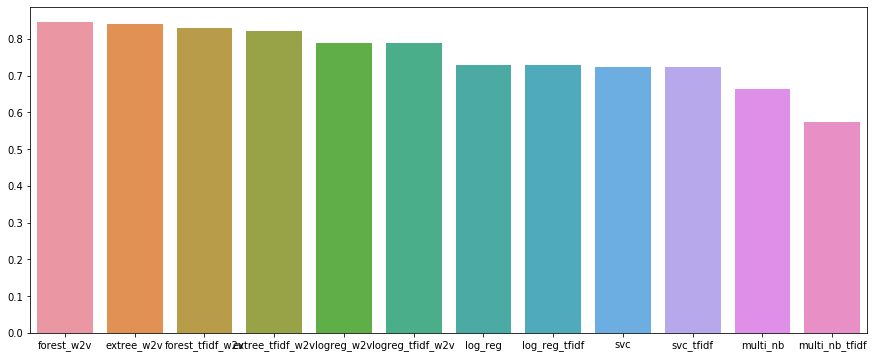

In [37]:
plt.figure(figsize = (15, 6))
sns.barplot(x = [name for name, _ in scores], y = [score for _, score in scores])

ok, this is how it is. Let's see how the ranking depends on the amount of training data. Word embedding models which are semi-supervised should shine when there is very little labeled training data

In [78]:
def benchmark(model, X, y, n):
    test_size = 1 - (n / float(len(y)))
    scores = []
    shufflesplit = StratifiedShuffleSplit(n_splits=5, test_size = test_size)
    for train, test in shufflesplit.split(X, y):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]
        scores.append(accuracy_score(model.fit(X_train, y_train).predict(X_test), y_test))
    return np.mean(scores)

In [81]:
%%time
train_sizes = [10, 40, 160, 640, 3200, 6400]
table = []
for name, model in all_models:
    for n in train_sizes:
        table.append({'model': name, 
                      'accuracy': benchmark(model, X, y, n), 
                      'train_size': n})
df = pd.DataFrame(table)

CPU times: user 2h 13min 29s, sys: 1min 51s, total: 2h 15min 20s
Wall time: 2h 12min 13s


[Text(0, 0.5, 'accuracy')]

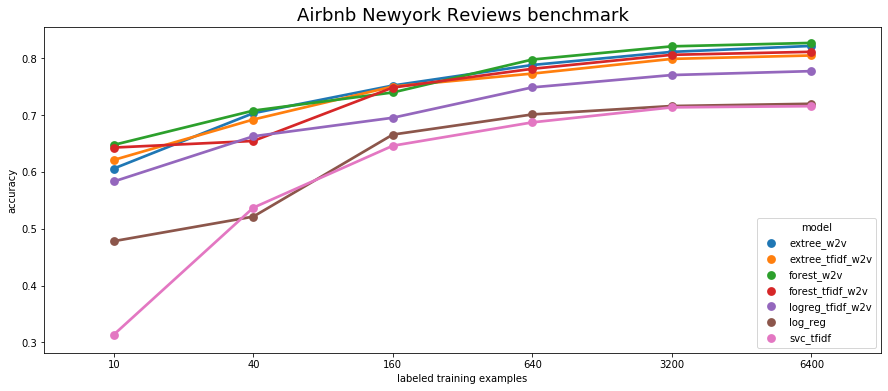

In [82]:
plt.figure(figsize = (15, 6))
fig = sns.pointplot(x = 'train_size', y = 'accuracy', hue = 'model', 
                    data = df[df.model.map(lambda x: x in ["forest_w2v", "extree_w2v", "svc_tfidf", "forest_tfidf_w2v", 
                                                         "extree_tfidf_w2v", "logreg_tfidf_w2v", "log_reg" 
                                                        ])])
sns.set_context("notebook", font_scale = 1.5)
fig.set(ylabel = "accuracy")
fig.set(xlabel = "labeled training examples")
fig.set(title = "Airbnb Newyork Reviews benchmark")
fig.set(ylabel = "accuracy")

In [39]:
def model(algorithm, X_train, X_test, y_train, y_test):
    model = algorithm
    alg_model = model.fit(X_train, y_train)
    global y_pred
    y_pred = alg_model.predict(X_test)
    
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    report = classification_report(y_test, y_pred)

    print('The accuracy of the classifier is {0}%'.format(accuracy))
    print('\nThe calculated RMSE is {0}'.format(rmse))
    print('\nThe classification report is as follows:\n')
    print(report)

In [47]:
model_selected = [("forest_w2v", forest_w2v), ("extree_w2v", extree_w2v),
                  ("forest_tfidf_w2v",forest_tfidf_w2v), ("extree_tfidf_w2v", extree_tfidf_w2v)]

In [51]:
%%time

for i, j in zip(model_selected, range(1, len(model_selected)+1)):
    print('\nTest to model {} ...'.format(i[0]))
    model(i[1], X_train, X_test, y_train, y_test)


Test to model forest_w2v ...
The accuracy of the classifier is 84.52%

The calculated RMSE is 0.453000625450753

The classification report is as follows:

              precision    recall  f1-score   support

           0       0.85      0.75      0.80      5118
           1       0.82      0.83      0.82      8089
           2       0.87      0.92      0.90      7908

    accuracy                           0.85     21115
   macro avg       0.85      0.83      0.84     21115
weighted avg       0.84      0.85      0.84     21115


Test to model extree_w2v ...
The accuracy of the classifier is 83.76%

The calculated RMSE is 0.47249720758633956

The classification report is as follows:

              precision    recall  f1-score   support

           0       0.84      0.76      0.80      5118
           1       0.84      0.78      0.81      8089
           2       0.84      0.95      0.89      7908

    accuracy                           0.84     21115
   macro avg       0.84      0.83

Random Forest accuracy gets the best score among others, which is 85% and the data does not underfit or overfit after we check it with cross validation. So, we can use this model for machine learning.

### Trying Grid Search for Hyperparameter Tuning

In [87]:
forest_w2v.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'text preprocessing', 'word2vec vectorizer', 'random forest', 'random forest__bootstrap', 'random forest__ccp_alpha', 'random forest__class_weight', 'random forest__criterion', 'random forest__max_depth', 'random forest__max_features', 'random forest__max_leaf_nodes', 'random forest__max_samples', 'random forest__min_impurity_decrease', 'random forest__min_impurity_split', 'random forest__min_samples_leaf', 'random forest__min_samples_split', 'random forest__min_weight_fraction_leaf', 'random forest__n_estimators', 'random forest__n_jobs', 'random forest__oob_score', 'random forest__random_state', 'random forest__verbose', 'random forest__warm_start'])

In [88]:
# Utility function to report best scores
def report(grid_scores, n_top):
    top_scores = sorted(grid_scores, key = itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.4f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [94]:
n_estimators = [200, 500]
# min_samples_split = [5, 10]
# min_samples_leaf = [3, 5]
max_depth = [5, 10, None]

param = {'random forest__n_estimators': n_estimators,
         'random forest__max_depth': max_depth}


In [96]:
%%time
grid_search = GridSearchCV(forest_w2v, param_grid = param, cv = skfold, n_jobs = 1)
grid_search.fit(X_train, y_train)
grid_search.best_score_

CPU times: user 4h 10min 16s, sys: 4.91 s, total: 4h 10min 21s
Wall time: 4h 10min 16s


0.8463296234904096

In [97]:
grid_search.best_params_

{'random forest__max_depth': None, 'random forest__n_estimators': 500}

We can just do parameter tuning, but for this dataset I have a limitation, which is the ability of the computer processing power that is not able and requires quite a long time.

In [84]:
skfold = StratifiedKFold(n_splits = 5, random_state = 42)

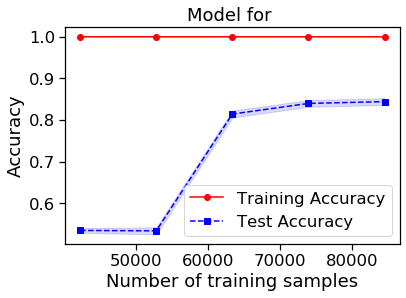

CPU times: user 2h 44min 8s, sys: 5.44 s, total: 2h 44min 13s
Wall time: 2h 44min 10s


In [99]:
%%time
def learning_curve(series, name =''):
    train_sizes, train_scores, test_scores = learning_curve(
                                estimator = forest_w2v,
                                X = series,
                                y = y,
                                train_sizes = np.linspace(0.5, 1.0, 5),
                                cv = skfold)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plot = plt.plot(train_sizes, train_mean, color='red', marker='o', label='Training Accuracy')
    
    plt.fill_between(train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15, color='red')


    plt.plot(train_sizes, test_mean, color='blue', linestyle='--', marker='s', 
        label='Test Accuracy')
    plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='blue')

    plt.title('Model for '.format(name))
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    return plot

learning_curve(X, name ='Comments_Meaningful')

In [100]:
forest_w2v = Pipeline([ ("text preprocessing", preprocessing()),
                        ("word2vec vectorizer", MeanFeatureVecs(w2v)), 
                        ("random forest", RandomForestClassifier(n_estimators = 200))])

In [104]:
forest_w2v.fit(newyork_reviews['comments_meaningful'], newyork_reviews['target'])

Pipeline(memory=None,
         steps=[('text preprocessing',
                 <__main__.preprocessing object at 0x7f3e8c3ed5d0>),
                ('word2vec vectorizer',
                 <__main__.MeanFeatureVecs object at 0x7f3e8c3ed550>),
                ('random forest',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=200, n_jobs=None,
                                        oob_score=False, random_sta

In [123]:
pickle.dump(forest_w2v, open('model_predict_airbnb_review.pkl', 'wb'))

In [124]:
forest_w2v.predict(['Good host and nice room'])

array([2])

In [125]:
forest_w2v.predict_proba(['Good host and nice room'])

array([[0.025, 0.35 , 0.625]])

In [144]:
def predict(text, include_neutral=True):
    # Tokenize text
    x_test1 = text
    # Predict
    score = forest_w2v.predict([x_test1])[0]
    proba = forest_w2v.predict_proba([x_test1])[0, score]
    score_prob = round(proba*100,2)
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score_prob)}

def decode_sentiment(score):
    if score == 0:        
        label = 'NEGATIVE'
    elif score == 1:
        label = 'NEUTRAL'
    else:
        label = 'POSITIVE'
    return label

In [132]:
predict("bad communication")

{'label': 'NEGATIVE', 'score': 96.5}